# Contact Maps

The file `contact_map.py` includes some tricks to study contact maps in protein dynamics, based on tools in MDTraj. This notebook shows examples as serves as documentation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from dok2ax import dok2plt

In [2]:
source = 'vreede'
run = 'run3'
if source == 'vreede':
    current_dir = '/home/sanderroet/Ras-JV/'+run+'/analysis/'
    name = 'vreede_'+run
elif source == 'carbon':
    current_dir = '/home/sanderroet/carbon/kras_100ns/'+run+'/analysis/'
    name = 'carbon_'+run
xtc = current_dir + 'vis-md.xtc'
pdb = current_dir + 'vis-md.pdb'

In [3]:
import mdtraj as md
traj = md.load(xtc, top=pdb)
topology = traj.topology
print(topology)

<mdtraj.Topology with 1 chains, 6832 residues, 22561 atoms, 15873 bonds>


In [4]:
newtop = topology.subset([])
oldtop = topology
for i in ['protein', 'resname GTP', 'element Mg']:
    temp1 = oldtop.select(i)
    temp2 = oldtop.select('not '+i)
    temp3 = oldtop.subset(temp1)
    oldtop = oldtop.subset(temp2)
    newtop = newtop.join(temp3)
newtop = newtop.join(oldtop)
traj.topology = newtop
topology = traj.topology
print(topology)

<mdtraj.Topology with 4 chains, 6832 residues, 22561 atoms, 15873 bonds>


In [5]:
from contact_map import ContactMap, ContactFrequency, ContactDifference

In [6]:
GTP_MG = topology.select('resname GTP or element Mg')
switch2 = topology.select('protein and resSeq 60 to 76 and not element H')
#for i in switch2:
#    print(topology.atom(i))

## Look at a single frame: `ContactMap`

First we make the contact map for the 0th frame. For default parameters (and how to change them) see section "Changing the defaults" below.

In [7]:
%%time
frame_contacts = ContactMap(traj[0], query=switch2)

CPU times: user 1.42 s, sys: 12.1 ms, total: 1.43 s
Wall time: 671 ms


Using markersize of 7 pixels.
CPU times: user 320 ms, sys: 12.8 ms, total: 332 ms
Wall time: 238 ms


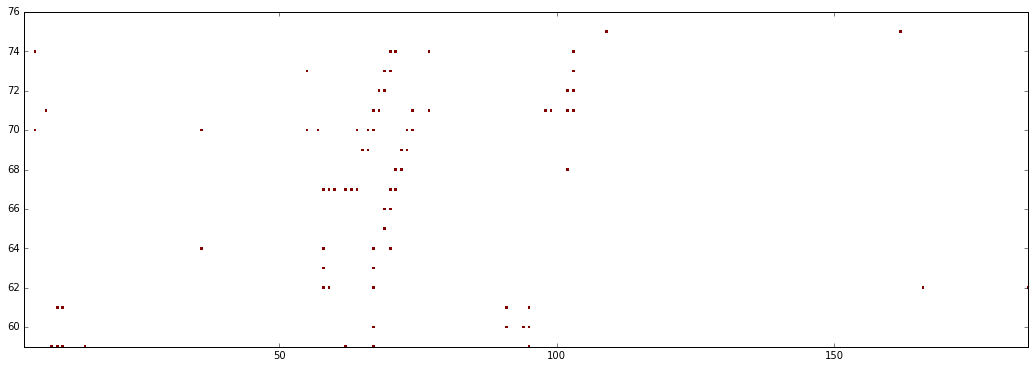

In [8]:
%%time
fig = dok2plt(frame_contacts.residue_contacts.sparse_matrix, ymin=59, ymax=76, figsize=(18,6))

If you wanted to, you could also plot all the atom-atom contacts. But that takes a lot longer, so it is commented out.

/home/sanderroet/scripts/dok2ax.py:38: UserWarning: Increased standard dpi from 80 to 437.
  +str(dpi)+'.')


Using markersize of 1 pixels.
CPU times: user 78 ms, sys: 4.16 ms, total: 82.2 ms
Wall time: 81.9 ms


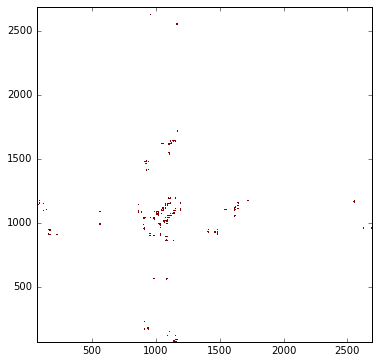

In [9]:
%%time
fig = dok2plt(frame_contacts.atom_contacts.sparse_matrix)


## Look at a trajectory: `ContactFrequency`

`ContactFrequency` finds the fraction of frames where each contact exists.

In [10]:
%%time
trajectory_contacts1 = ContactFrequency(traj[500:1500:10], query=switch2, cutoff=0.5)
trajectory_contacts2 = ContactFrequency(traj[8000:9000:10], query=switch2, cutoff=0.5)

CPU times: user 3min 42s, sys: 6.91 s, total: 3min 49s
Wall time: 1min 5s


In [11]:
# if you want to save this for later analysis
trajectory_contacts1.save_to_file(current_dir+"switch2_contacts500_1500.p")
trajectory_contacts2.save_to_file(current_dir+"switch2_contacts8000_9000.p")
# then load with ContactFrequency.from_file("traj_contacts.p")

In [12]:
#trajectory_contacts2 = ContactFrequency.from_file("/home/sanderroet/Ras-JV/run1/analysis/GTP_contacts9300_9800.p")

Using markersize of 6 pixels.
Using markersize of 6 pixels.
CPU times: user 115 ms, sys: 3.98 ms, total: 119 ms
Wall time: 119 ms


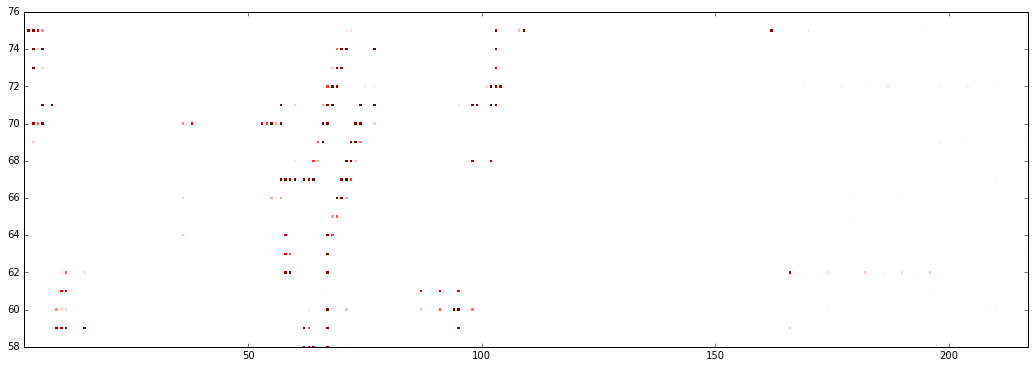

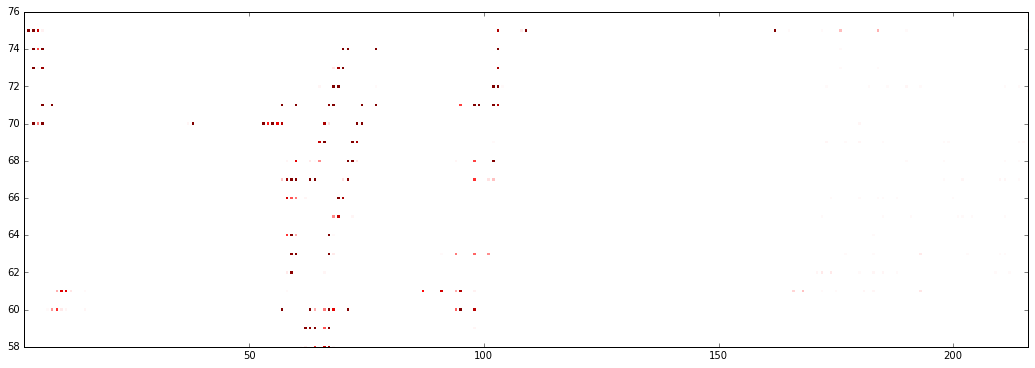

In [13]:
%%time
for i in [trajectory_contacts1,trajectory_contacts2]:
    fig, = dok2plt(i.residue_contacts.sparse_matrix, ymin=58, ymax=76, figsize=(18,6))

## Compare two: `ContactDifference`

If you want to compare two frequencies, you can use the `ContactDifference` class (or the shortcut for it, which is to subtract a contact frequency/map from another.)

The example below will compare the trajectory to its first frame.

In [14]:
%%time
diff = trajectory_contacts2 - trajectory_contacts1

CPU times: user 12.5 ms, sys: 18 µs, total: 12.5 ms
Wall time: 12.9 ms


A contact that appears in trajectory, but not in the frame, will be at +1 and will be shown in red below. A contact that appears in the frame, but not the trajectory, will be at -1 and will be shown in blue below. The values are the difference in the frequencies (of course, for a single frame, the frequency is always 0 or 1).

Using markersize of 6 pixels.
CPU times: user 89.2 ms, sys: 4.05 ms, total: 93.2 ms
Wall time: 91.7 ms


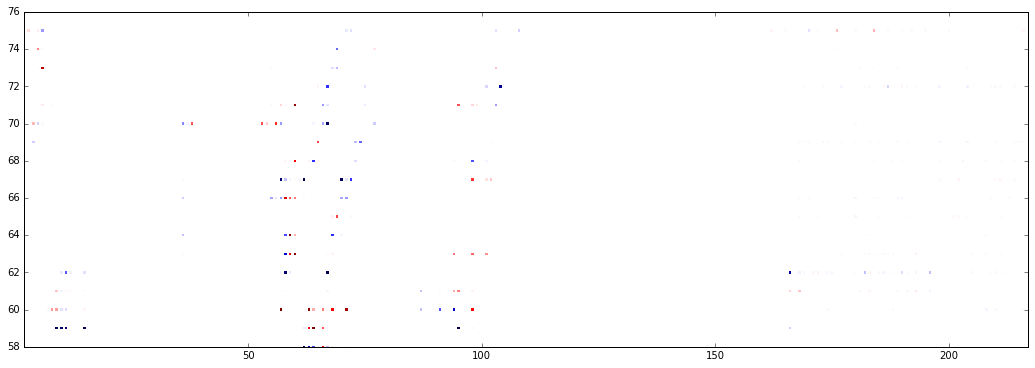

In [15]:
%%time
fig = dok2plt(diff.residue_contacts.sparse_matrix, ymin=58, ymax=76, figsize=(18,6))

### List the residue contacts that show the most difference

First we look at the frames that are much more important in the trajectory than the frame. Then we look at the frames that are more important in the frame than the trajectory.

The `.most_common()` method gives a list of the contact pairs and the frequency, sorted by frequency. See also `collections.Counter.most_common()` in the standard Python `collections` module.

Here we do this with the `ContactDifference` we created, although it works the same for `ContactFrequency` and `ContactMap` (with the single-frame contact map, the ordering is a bit nonsensical, since every entry is either 0 or 1).

In [16]:
%%time
# residue contact more important in trajectory than in frame (near +1)
diff.residue_contacts.most_common()[:10]

CPU times: user 938 µs, sys: 33 µs, total: 971 µs
Wall time: 980 µs


[([THR58, GLN61], 1.0),
 ([SER65, GLY60], 0.98),
 ([GLN61, TYR64], 0.96),
 ([GLN61, MET72], 0.87),
 ([THR74, VAL7], 0.8),
 ([MET67, ALA59], 0.66),
 ([GLY60, TYR64], 0.58),
 ([ASP69, GLN61], 0.5499999999999999),
 ([GLN99, GLN61], 0.5),
 ([ASP57, TYR71], 0.41999999999999993)]

In [17]:
# residue contact more important in frame than in trajectory (near -1)
list(reversed(diff.residue_contacts.most_common()))[:]
# alternate: diff.residue_contacts.most_common()[:-10:-1] # (thanks Sander!)

[([GLY60, TYR96], -1.0),
 ([GLY10, GLY60], -1.0),
 ([ARG68, GLU63], -1.0),
 ([GLY60, LYS16], -0.97),
 ([ARG68, TYR71], -0.94),
 ([ALA11, GLY60], -0.91),
 ([ALA59, GLU63], -0.9099999999999999),
 ([THR58, ARG68], -0.89),
 ([GLY12, GLY60], -0.82),
 ([ARG73, ASP105], -0.8099999999999999),
 ([GTP201, GLU63], -0.77),
 ([GLN61, HIS95], -0.6799999999999999),
 ([ALA59, TYR64], -0.62),
 ([SER65, ASP69], -0.41),
 ([ARG73, ARG68], -0.4),
 ([SER65, ALA59], -0.36),
 ([GLN99, ASP69], -0.35),
 ([ASP92, GLN61], -0.34),
 ([GLY12, GLU63], -0.33),
 ([GLY75, GLN70], -0.3),
 ([GLU37, TYR71], -0.24),
 ([MET67, MET72], -0.2),
 ([GLU76, VAL7], -0.2),
 ([THR58, TYR71], -0.19999999999999996),
 ([THR58, MET67], -0.19),
 ([LYS104, MET72], -0.18999999999999995),
 ([MET67, LEU56], -0.18),
 ([MET67, TYR71], -0.17000000000000004),
 ([THR74, GLN70], -0.14),
 ([GLN61, LYS88], -0.12),
 ([SER65, GLU37], -0.12),
 ([NA6844, GLU63], -0.12),
 ([GLU62, LYS88], -0.12),
 ([NA6830, GLU63], -0.12),
 ([ALA59, ARG68], -0.12),
 ([LYS

### List the atoms contacts most common within a given residue contact

In [18]:
asp30 = topology.residue(29)
asp33 = topology.residue(32)
print(asp30, asp33)
gtp201= topology.residue(166)
mg202 = topology.residue(167)
print(gtp201, mg202)

ASP30 ASP33
GTP201 MG202


We extended the standard `.most_common()` to take an optional argument. When the argument is given, it will filter the output to only include the ones where that argument is part of the contact. For example, the following gives the residues most commonly in contact with GTP.

In [19]:
for contact in diff.residue_contacts.most_common(gtp201):
    print (contact)
for contact in diff.residue_contacts.most_common(mg202):
    print (contact)

([GLU62, GTP201], 0.08)
([GLY60, GTP201], -0.1)
([GTP201, GLU63], -0.77)


We can also find all the atoms, for all residue contacts, that are in contact with a given residue, and return that sorted by frequency.

In [20]:
diff.most_common_atoms_for_residue(gtp201)[:-15:-1]

[([GLU63-OE2, GTP201-O3G], -0.5),
 ([GTP201-O3G, GLU63-OE1], -0.48),
 ([GTP201-O3G, GLU63-CD], -0.34),
 ([GLU63-OE2, GTP201-O2G], -0.26),
 ([GTP201-O2G, GLU63-OE1], -0.25),
 ([GTP201-PG, GLU63-OE1], -0.24),
 ([GLU63-OE2, GTP201-PG], -0.18),
 ([GTP201-O3G, GLY60-N], -0.1),
 ([GTP201-O2G, GLU63-CD], -0.09),
 ([GLU63-OE2, GTP201-O1G], -0.03),
 ([GTP201-PG, GLU63-CD], -0.02),
 ([GTP201-O1G, GLU63-OE1], -0.01),
 ([GTP201-O3G, GLU62-CD], 0.01),
 ([GTP201-O2G, GLU62-CD], 0.01)]

Finally, we can look at which atoms are most commonly in contact within a given residue contact pair.

In [21]:
trajectory_contacts2.most_common_atoms_for_contact([gtp201, asp33])

[]

## Changing the defaults

This sections covers several options that you can modify to make the contact maps faster, and to focus on what you're most interested in.

The first three options change which atoms are included as possible contacts. The query atoms are the atoms which appear on the y-axis of the plot. The haystack atoms are those along the x-axis of the plot. In general, you should choose a query that is smaller than the haystack.

Both of these options take a list of atom index numbers. These are most easily created using MDTraj's atom selection language.

In [22]:
# the default selection is
default_selection = topology.select("not water and not symbol == 'H'")
print(len(default_selection))

1408


### Using a different query

In [23]:
switch1 = topology.select("protein and resSeq 32 to 38 and not symbol == 'H'")
switch2 = topology.select("protein and resSeq 59 to 67 and not symbol == 'H'")
gtp = topology.select("resname GTP and not symbol == 'H'")
mg = topology.select("element Mg")
cations = topology.select("resname NA or resname MG")
sodium = topology.select("resname NA")

In [24]:
%%time
sw1_contacts = ContactFrequency(trajectory=traj[::100], query=switch1)

CPU times: user 1min 44s, sys: 3.38 s, total: 1min 48s
Wall time: 31.6 s


Using markersize of 9 pixels.
CPU times: user 63.1 ms, sys: 100 µs, total: 63.2 ms
Wall time: 61.8 ms


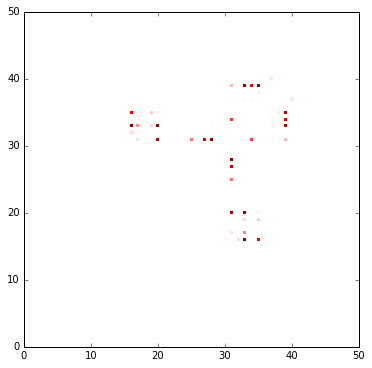

In [25]:
%%time
fig, = dok2plt(sw1_contacts.residue_contacts.sparse_matrix, xmin=0, xmax = 50, ymin=0, ymax=50)

### Using a different haystack

Currently, changing the haystack has essentially no effect on the performance. However, I expect to change that in the  future (requires making some modifications to MDTraj).

In [26]:
%%time
cations_switch1 = ContactFrequency(trajectory=traj[::100], query=cations, haystack=switch1)

CPU times: user 1min 44s, sys: 3.39 s, total: 1min 47s
Wall time: 30.5 s


Using markersize of 2 pixels.
CPU times: user 365 ms, sys: 3.98 ms, total: 369 ms
Wall time: 214 ms


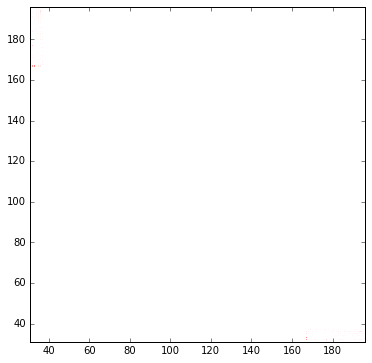

In [27]:
%%time
fig, = dok2plt(cations_switch1.residue_contacts.sparse_matrix)

### Changing how many neighboring residues are ignored

By default, we ignore atoms from 2 residues on either side of the given residue (and in the same `chain`). This is easily changed. However, even when you say to ignore no neighbors, you still ignore the residue's interactions with itself.

Note: for non-protein contact, the `chain` is often poorly defined. In this example, the GTP and the Mg are listed sequentially in residue order, and therefore they are considered "neighbors" and their contacts are ignored.

In [28]:
%%time
ignore_none = ContactFrequency(trajectory=traj[::100], n_neighbors_ignored=0)

CPU times: user 2min 9s, sys: 4.1 s, total: 2min 13s
Wall time: 39.6 s


Using markersize of 2 pixels.
CPU times: user 317 ms, sys: 20 ms, total: 337 ms
Wall time: 209 ms


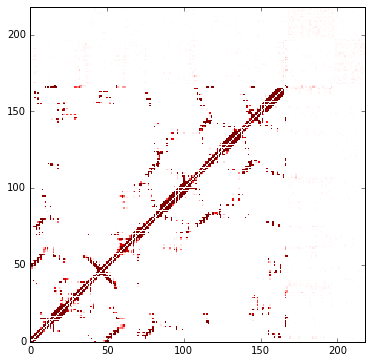

In [29]:
%%time
fig, = dok2plt(ignore_none.residue_contacts.sparse_matrix)